This notebook is used to visualize the attention patterns of the original GPT-2 model and the model without LayerNorm. Most attention patterns are similar except for 11.11 attention sinks are visibly reduced.

In [1]:
import torch
from std_dicts import std_dicts
from transformers import GPT2LMHeadModel, AutoTokenizer
from utils import remove_layernorm_by_scaling

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

/Users/submarat/workplace/removing-layer-norm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model(model_id, remove_ln=False):
    # Load the model and tokenizer using your Hugging Face Hub model ID
    
    # Load the model
    model = GPT2LMHeadModel.from_pretrained(model_id)
    model = model.to(device)

    if remove_ln:
        model = remove_layernorm_by_scaling("gpt2", model)
    
    # Load the tokenizer
    model_type = model.config.model_type
    tokenizer = AutoTokenizer.from_pretrained(model_type)
    tokenizer.eos_token = tokenizer.eos_token
    
    return model, tokenizer

def sample(model, tokenizer, prompt, max_length=50, num_return_sequences=1, temperature=0.7):
    # Example usage
    text = prompt
    inputs = tokenizer(text, return_tensors="pt")
    inputs.to(device)
    
    # Generate text using sampling
    outputs = model.generate(
        inputs["input_ids"],
        max_length=50,  # Adjust max length as needed
        num_return_sequences=1,
        do_sample=True,
        temperature=0.7,  # Adjust temperature to control randomness (higher = more random)
        attention_mask=inputs["attention_mask"],
    )
    
    # Decode the outputs
    decoded_outputs = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    print(decoded_outputs)

In [3]:
model, tokenizer = load_model("gpt2", remove_ln=False)
sample(model, tokenizer, "to be or not to")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


to be or not to be), and to be or not to be.

(4) Each person who is not a registered sex offender and who is not a sex offender has the right of appeal to the Divisional Court of Appeal.



In [4]:
model, tokenizer = load_model("submarat/model-without-ln")
sample(model, tokenizer, "to be or not to")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


to be or not to be.

The problem is that you can't really use your own money, as I've been doing for the past five years or so. You don't have to be the “real deal”.



Loading models...
Comparing attention patterns for prompt: 'The quick brown fox jumps over the lazy dog'
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
torch.Size([1, 12, 9, 9])
Sink rates:  tensor(0.8665, device='mps:0') tensor(0.8171, device='mps:0')


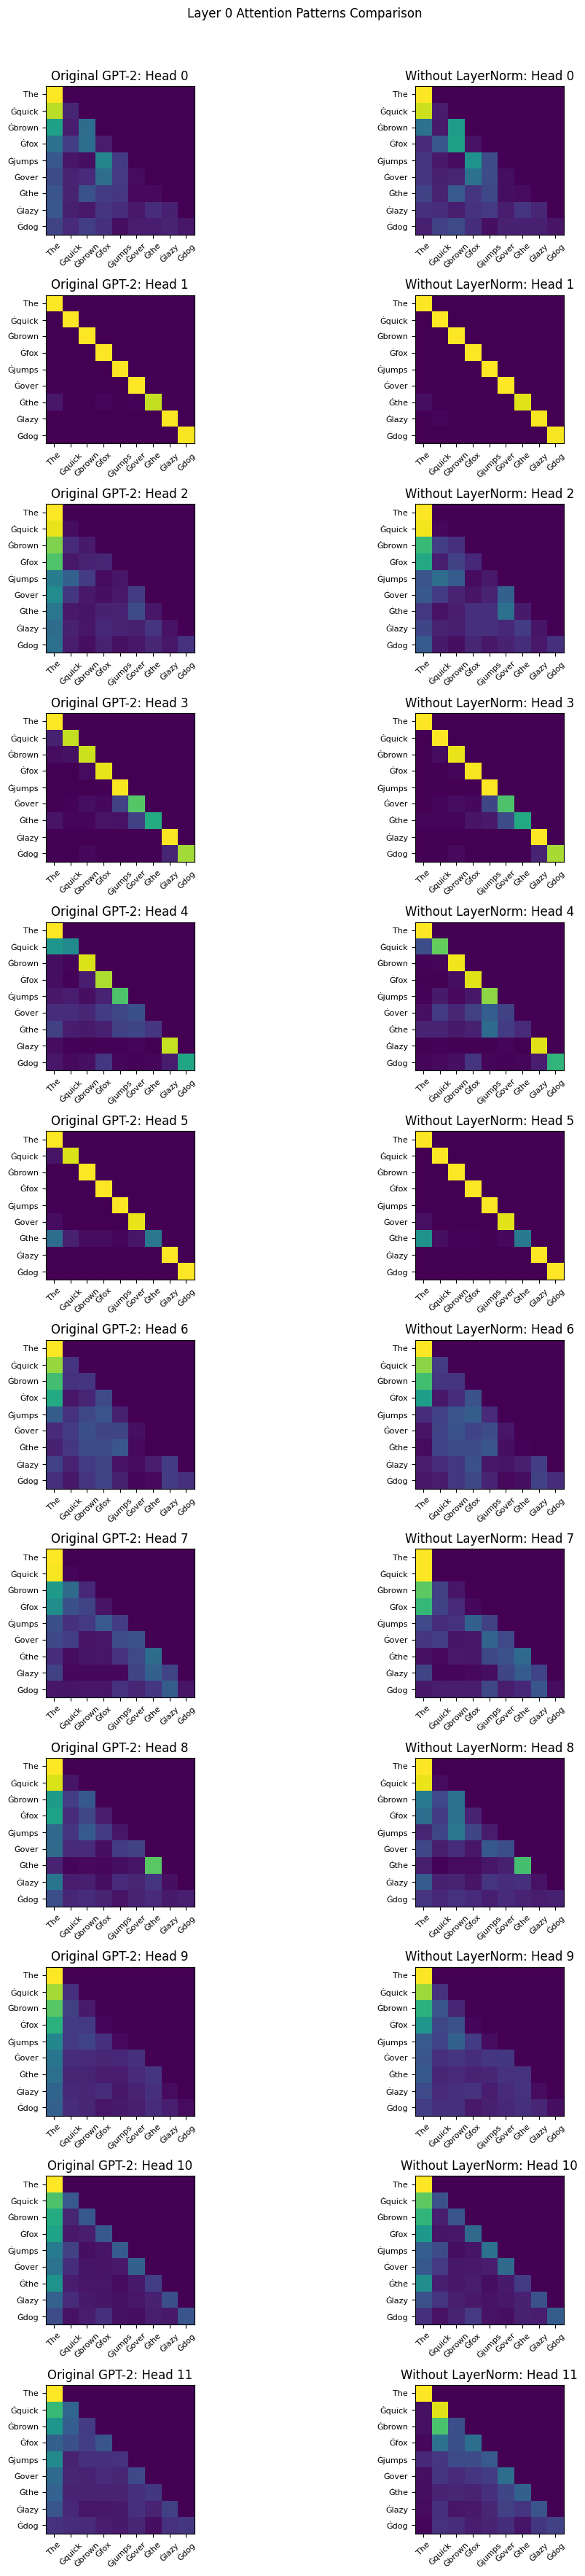

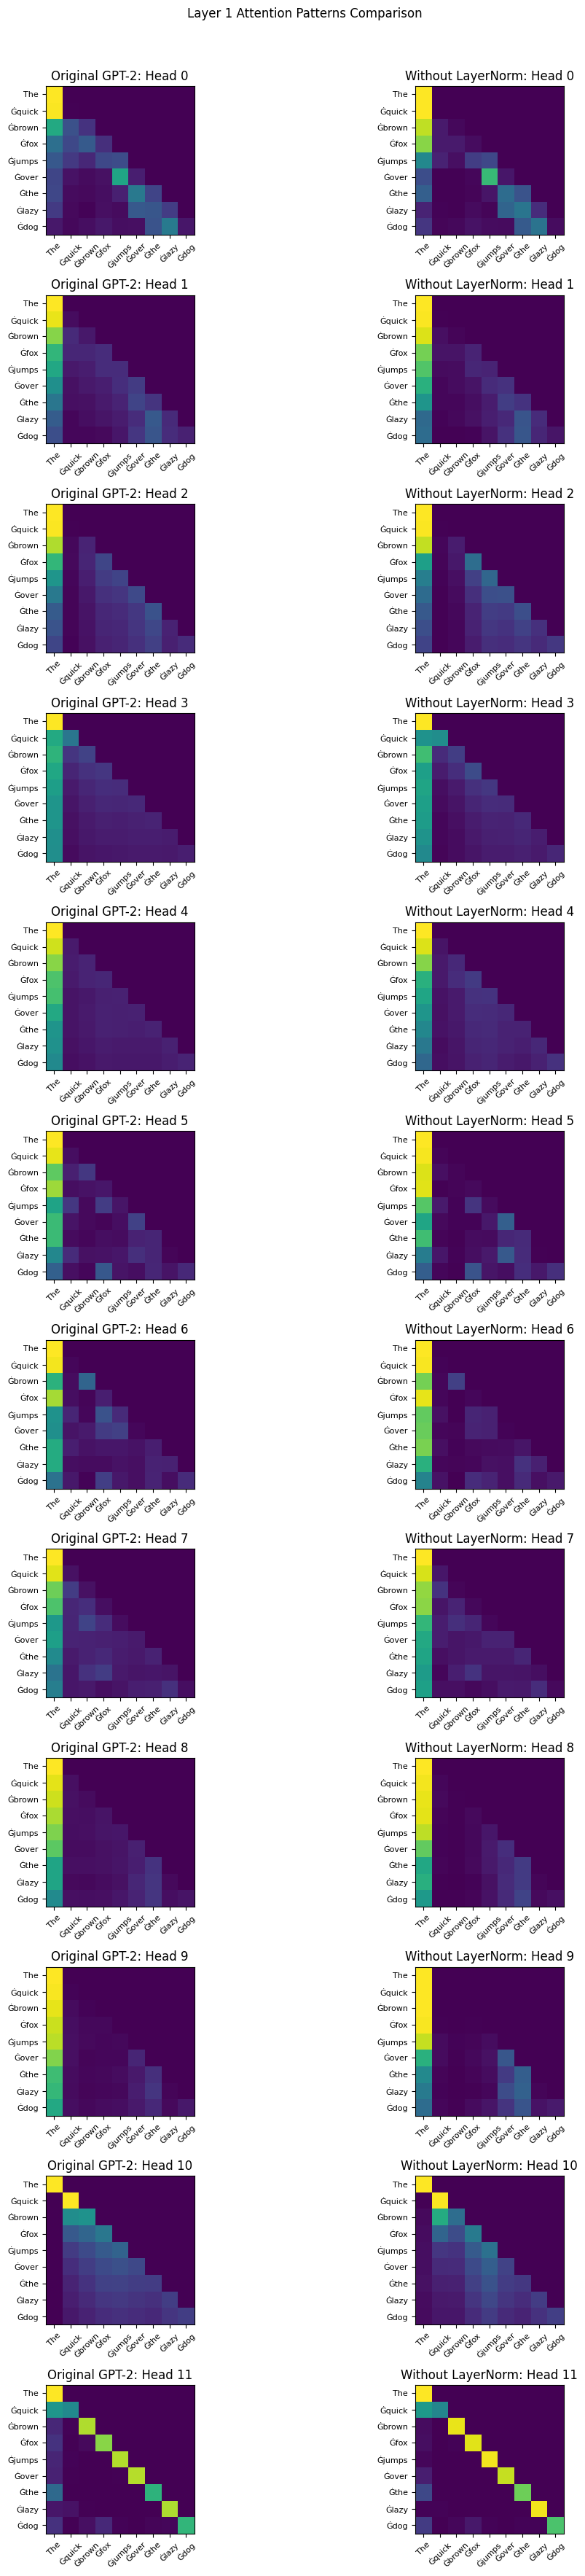

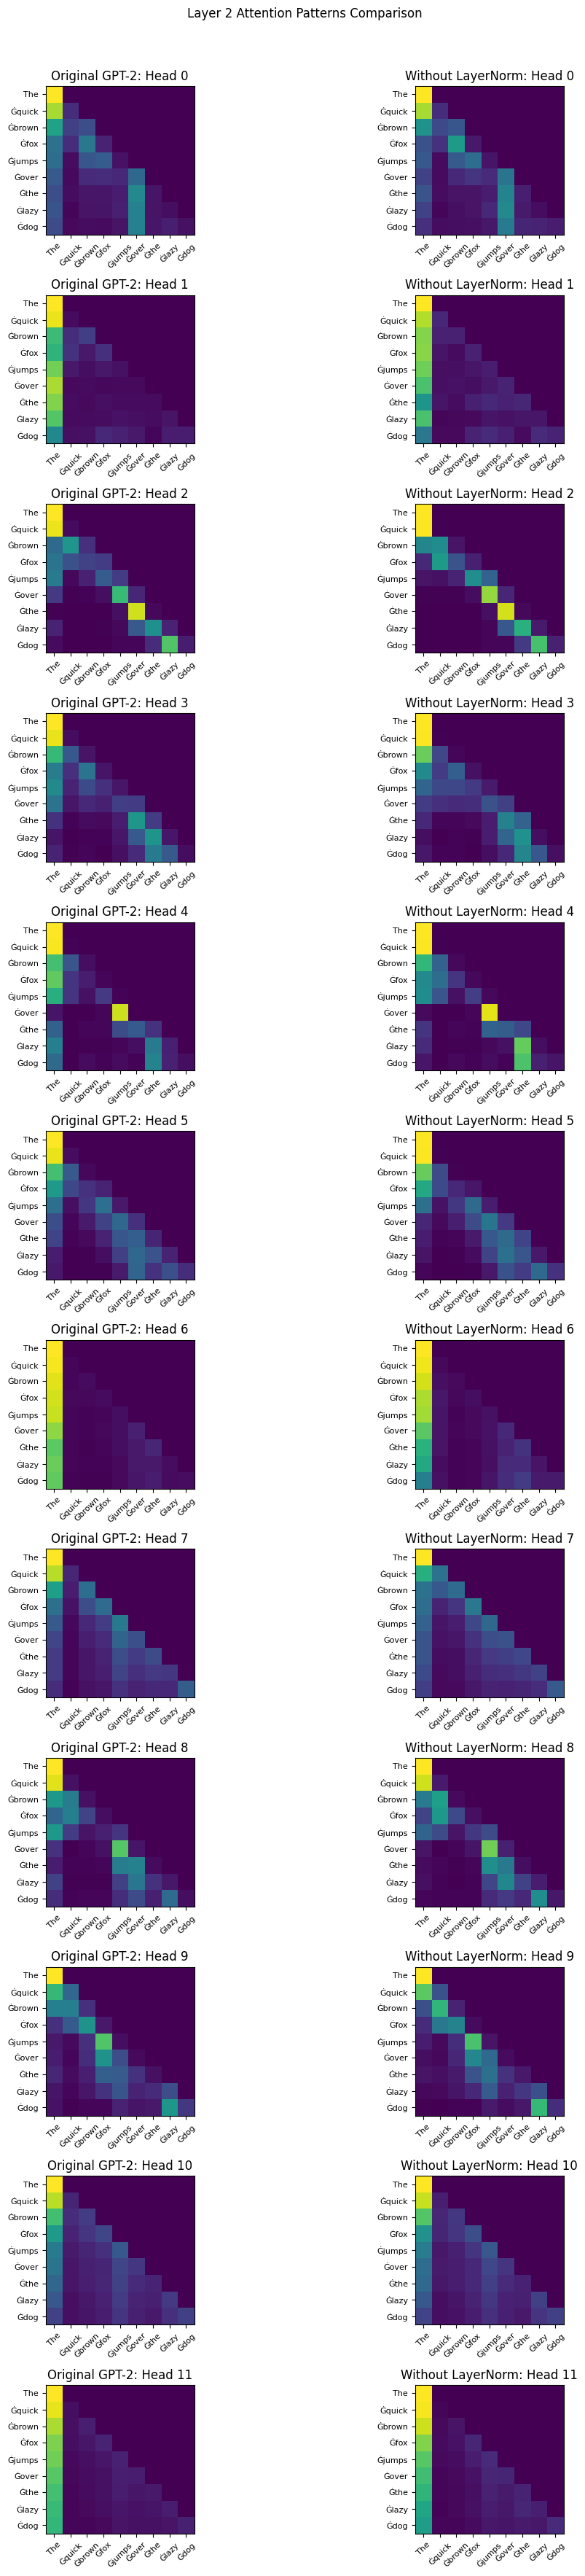

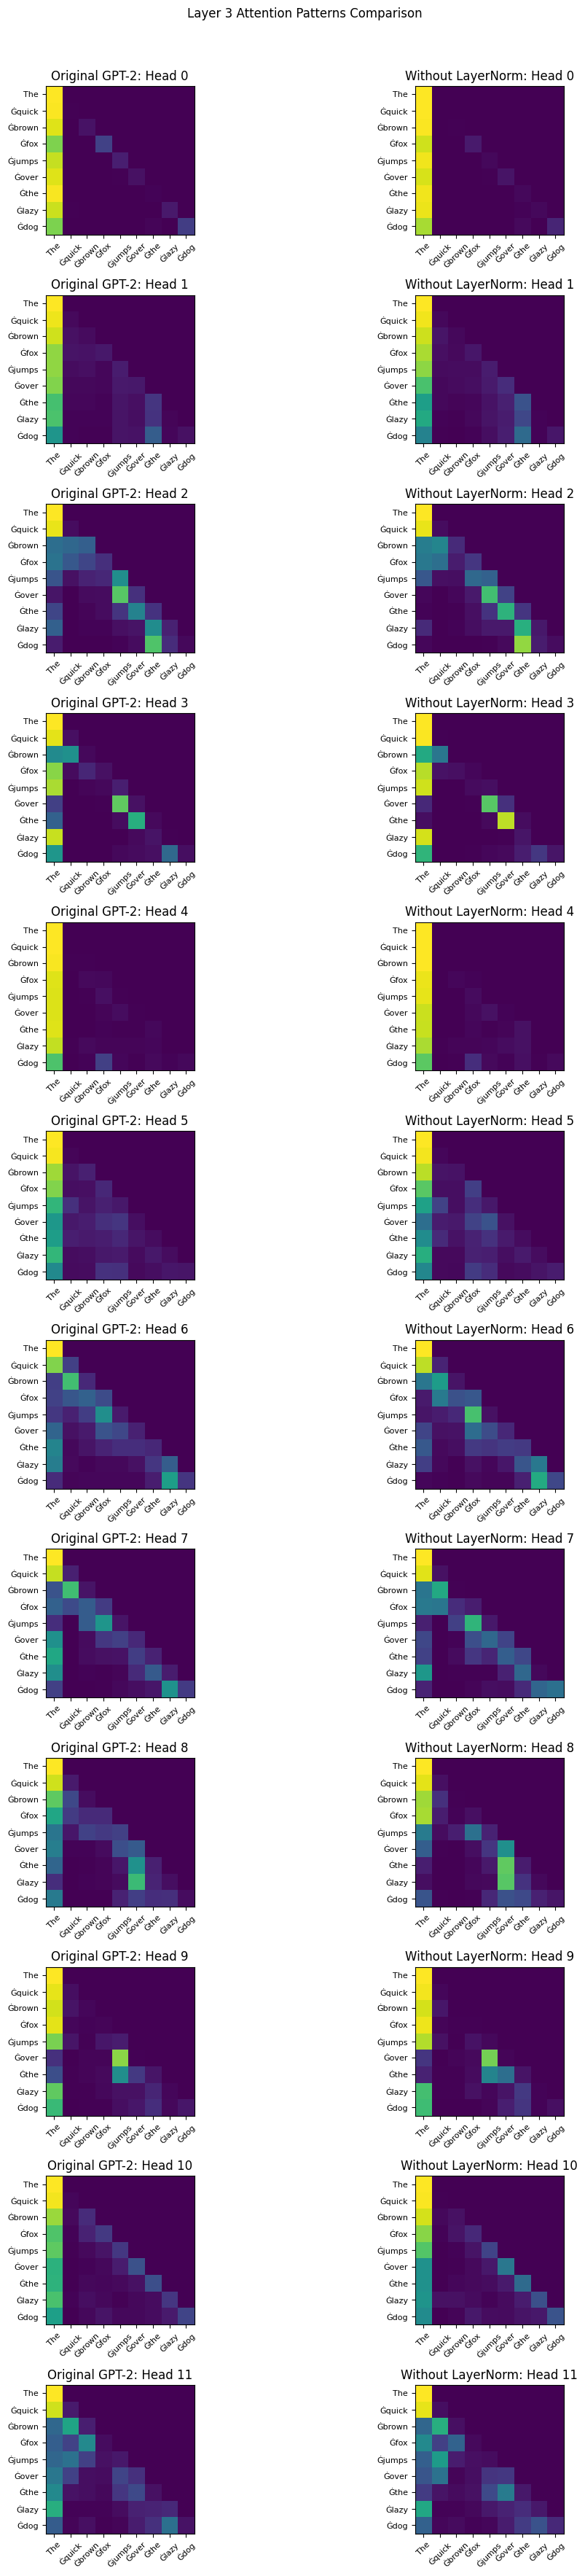

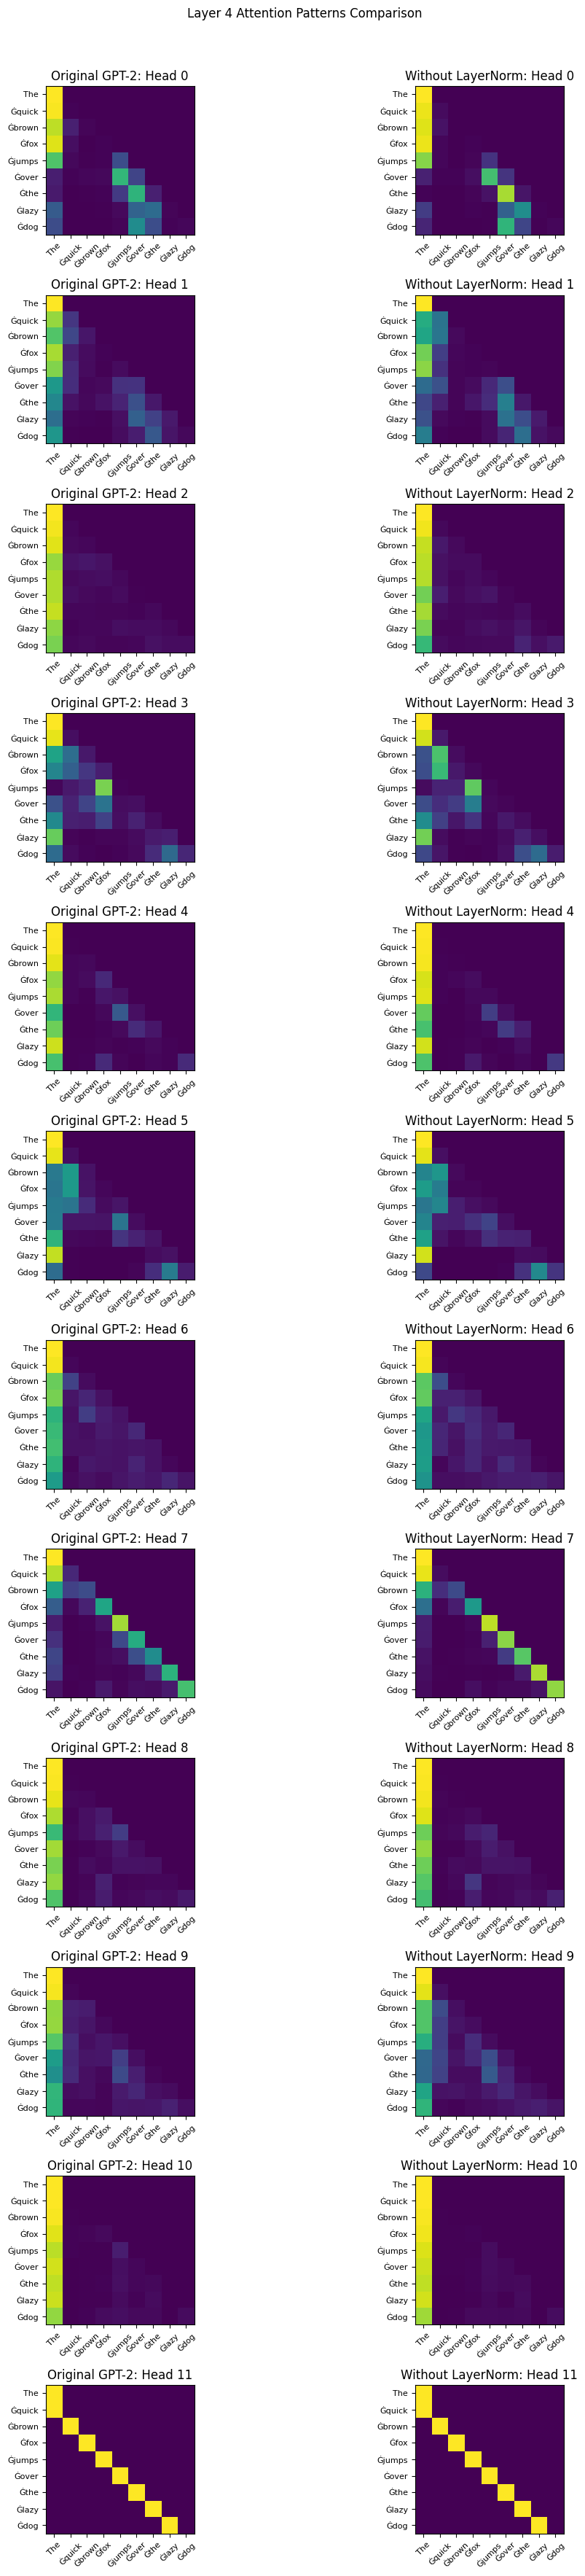

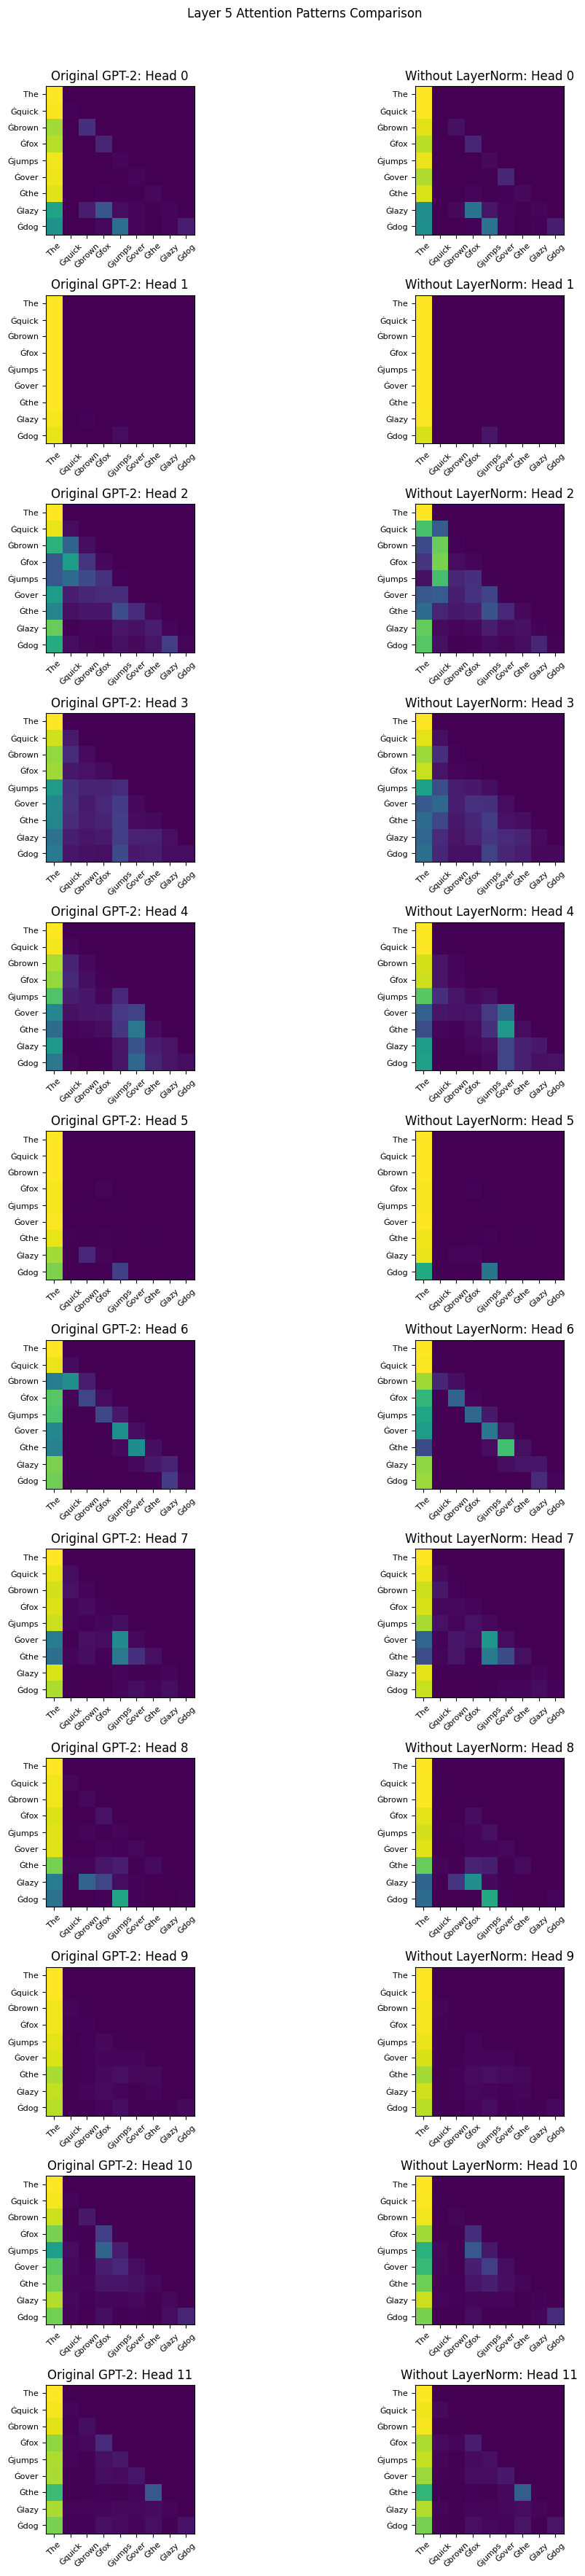

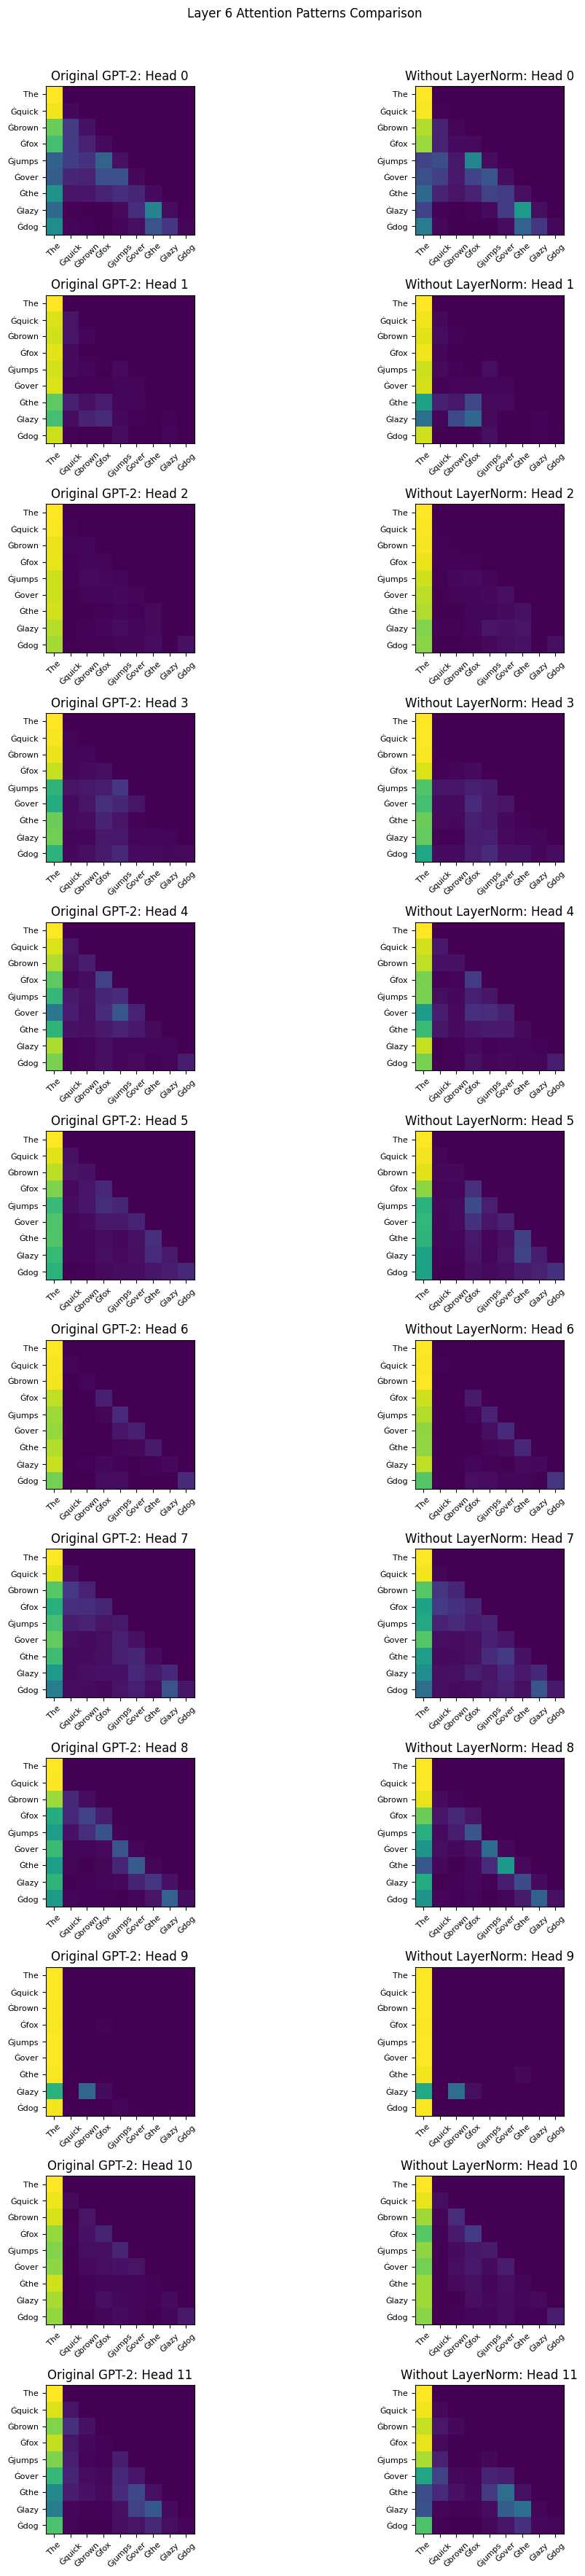

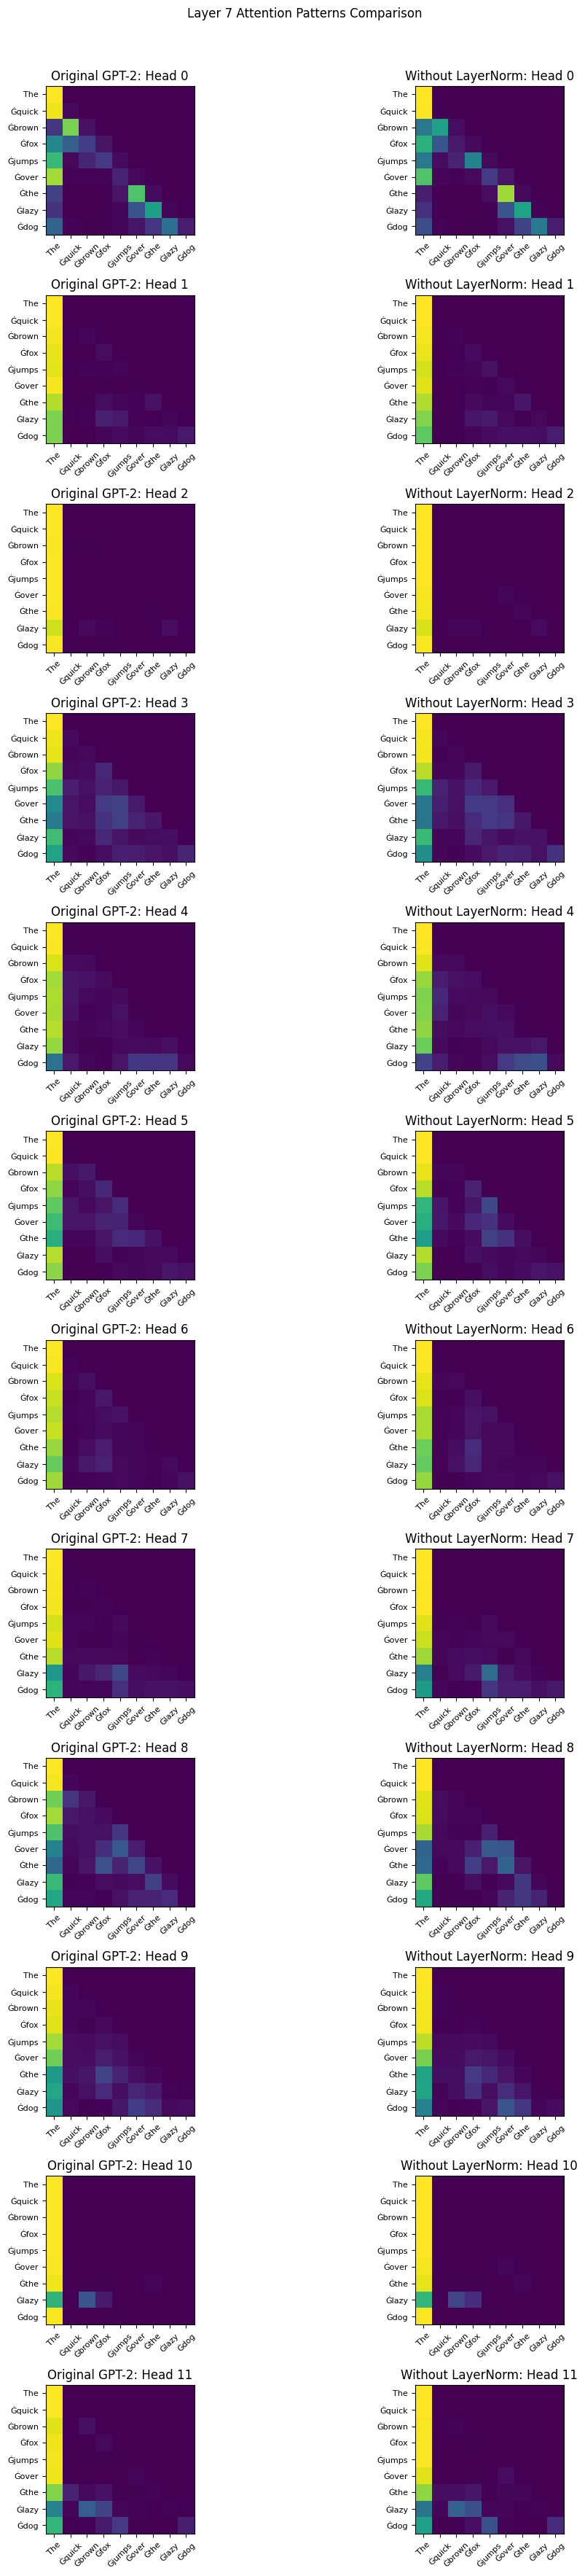

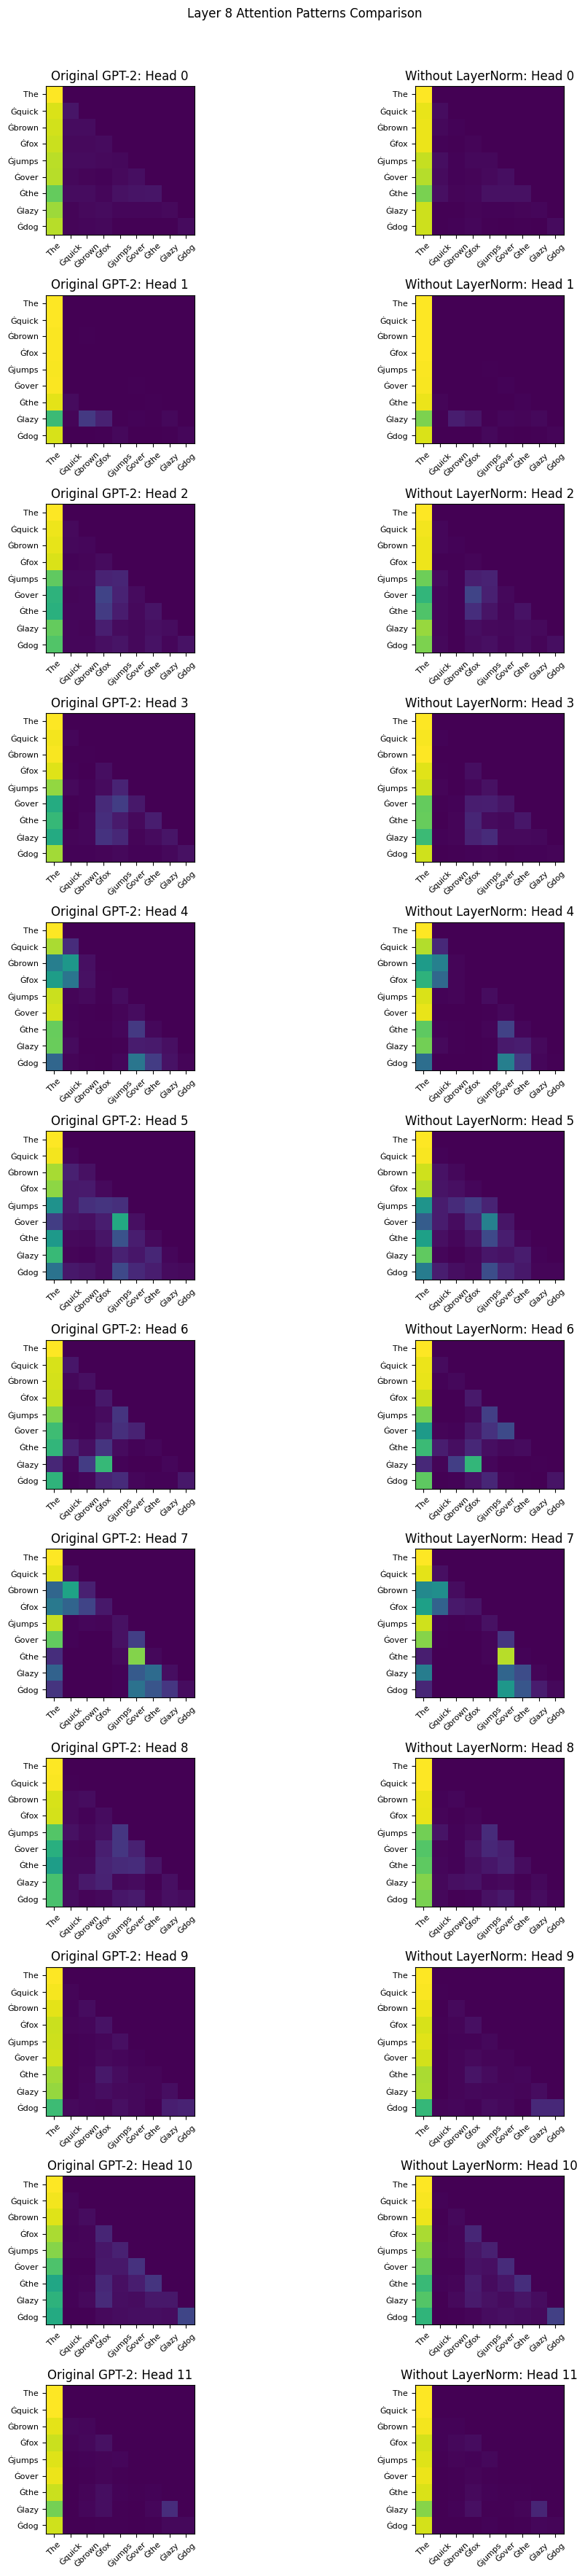

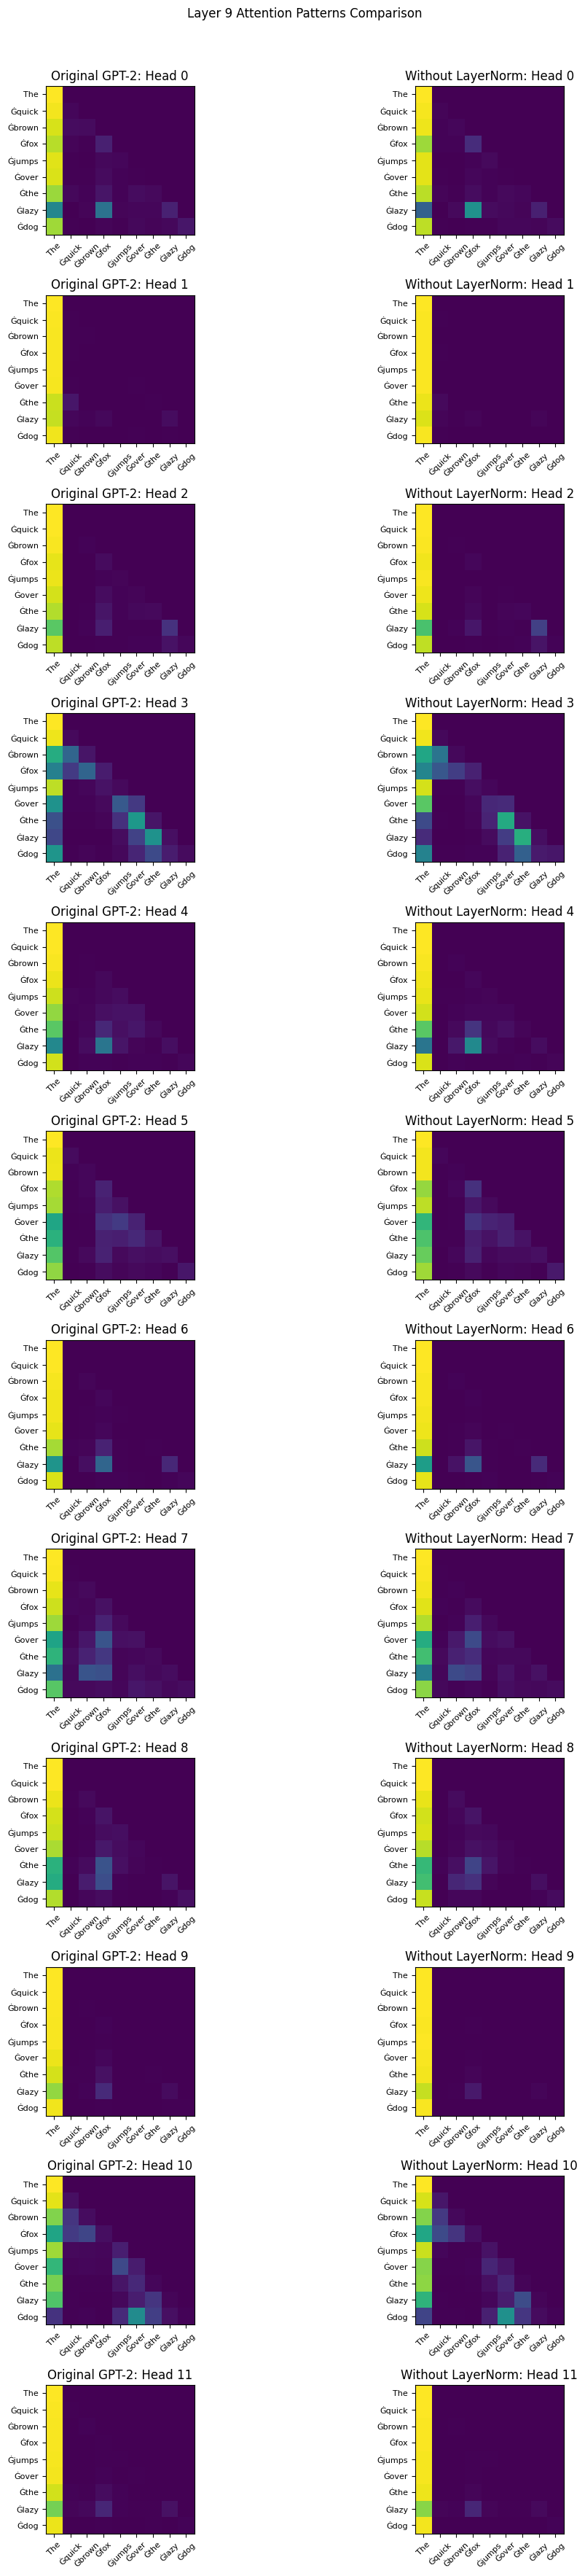

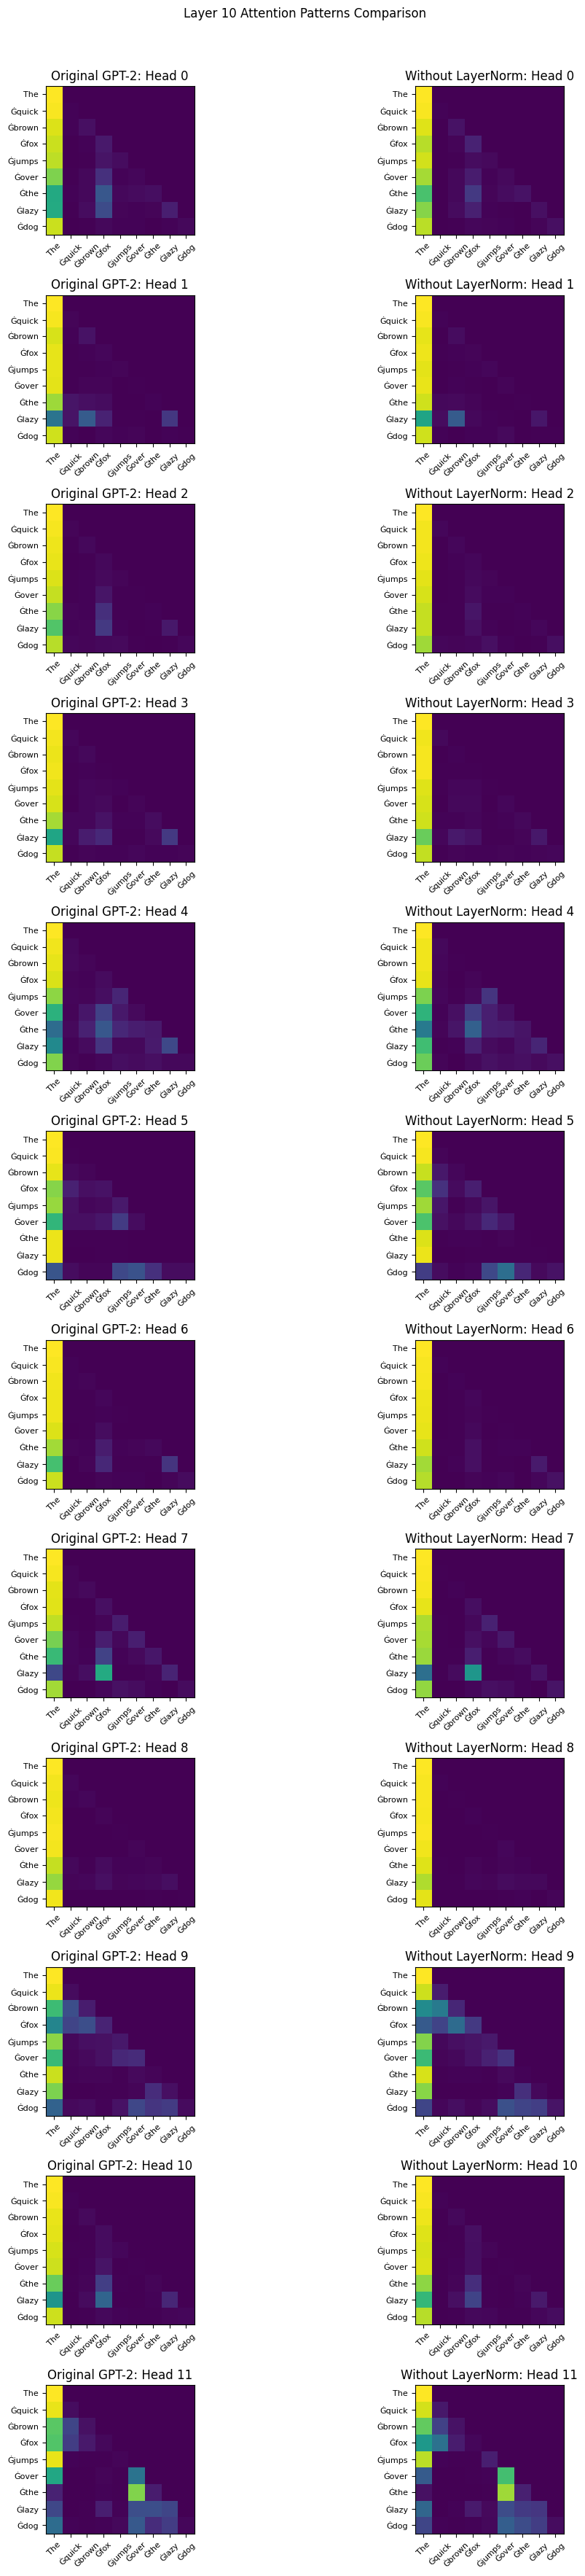

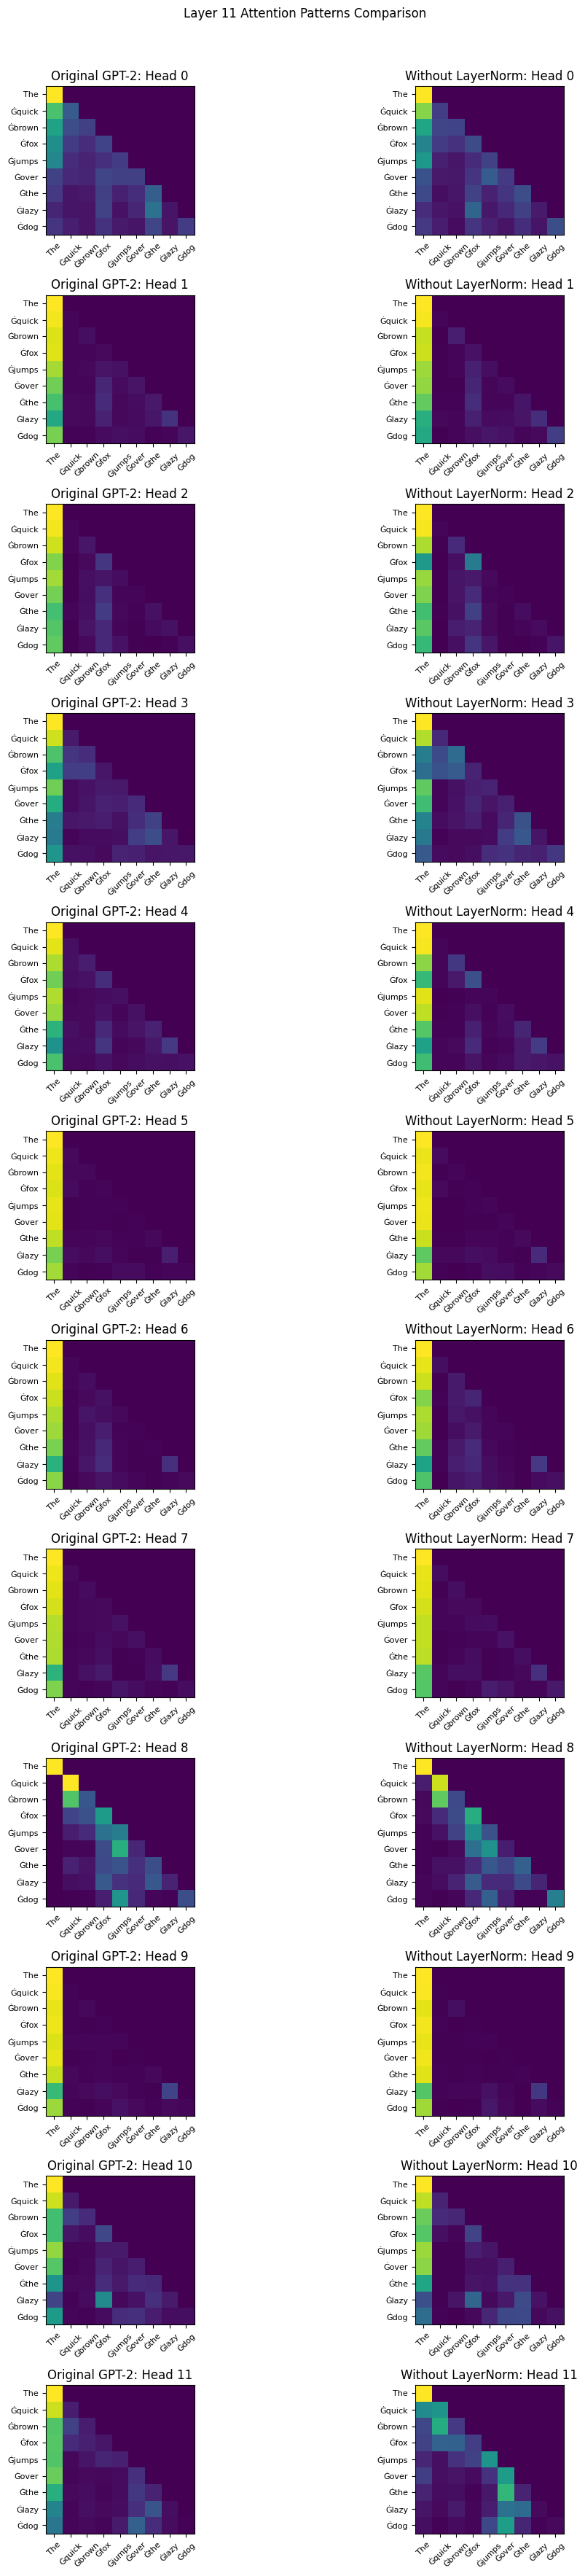

In [16]:
from utils import calculate_sink_rate 

def visualize_attention_comparison(model1, tokenizer1, model2, tokenizer2, prompt):
    # Prepare input for both models
    inputs1 = tokenizer1(prompt, return_tensors="pt")
    inputs1 = {k: v.to(device) for k,v in inputs1.items()}
    
    inputs2 = tokenizer2(prompt, return_tensors="pt")
    inputs2 = {k: v.to(device) for k,v in inputs2.items()}
    
    # Get attention patterns for both models
    with torch.no_grad():
        outputs1 = model1(**inputs1, output_attentions=True)
        outputs2 = model2(**inputs2, output_attentions=True)
    
    # Get attention tensors
    attention1 = outputs1.attentions
    attention2 = outputs2.attentions

    # Calculate the sink rate for both models
    sink_rate1 = calculate_sink_rate(model1, attention1)
    sink_rate2 = calculate_sink_rate(model2, attention2)
    print("Sink rates: ", sink_rate1, sink_rate2)
    
    # Plot attention patterns side by side
    import matplotlib.pyplot as plt
    
    num_layers = len(attention1)
    num_heads = attention1[0].shape[1]
    tokens1 = tokenizer1.convert_ids_to_tokens(inputs1['input_ids'][0])
    tokens2 = tokenizer2.convert_ids_to_tokens(inputs2['input_ids'][0])
    
    for layer in range(num_layers):
        fig, axes = plt.subplots(num_heads, 2, figsize=(12, 3*num_heads))
        fig.suptitle(f'Layer {layer} Attention Patterns Comparison')
        
        for head in range(num_heads):
            # Get attention weights for both models
            attn1 = attention1[layer][0, head].cpu()
            attn2 = attention2[layer][0, head].cpu()
            
            # Plot heatmaps side by side
            im1 = axes[head, 0].imshow(attn1, cmap='viridis')
            axes[head, 0].set_title(f'Original GPT-2: Head {head}')
            
            im2 = axes[head, 1].imshow(attn2, cmap='viridis')
            axes[head, 1].set_title(f'Without LayerNorm: Head {head}')
            
            # Set tick labels for first column
            if len(tokens1) < 10:  # Only show ticks for reasonably short sequences
                axes[head, 0].set_xticks(range(len(tokens1)))
                axes[head, 0].set_yticks(range(len(tokens1)))
                axes[head, 0].set_xticklabels(tokens1, rotation=45, fontsize=8)
                axes[head, 0].set_yticklabels(tokens1, fontsize=8)
                
                axes[head, 1].set_xticks(range(len(tokens2)))
                axes[head, 1].set_yticks(range(len(tokens2)))
                axes[head, 1].set_xticklabels(tokens2, rotation=45, fontsize=8)
                axes[head, 1].set_yticklabels(tokens2, fontsize=8)
            else:
                # For longer sequences, skip detailed labels
                axes[head, 0].set_xticks([])
                axes[head, 0].set_yticks([])
                axes[head, 1].set_xticks([])
                axes[head, 1].set_yticks([])
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

# Load both models
print("Loading models...")
model_original, tokenizer_original = load_model("gpt2", remove_ln=False)
model_no_ln, tokenizer_no_ln = load_model("submarat/model-without-ln")

# Example usage with side-by-side comparison
prompt = "The quick brown fox jumps over the lazy dog"
print(f"Comparing attention patterns for prompt: '{prompt}'")
visualize_attention_comparison(model_original, tokenizer_original, model_no_ln, tokenizer_no_ln, prompt)